In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd

warnings.filterwarnings('ignore')

In [8]:
mae = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='MAE')
maemean = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='MAEMEAN')
rmse = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='RMSE')
# mape = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='MAPE')
ppe_value = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='PPE(Value)')
ppe_time = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='PPE(Time)')

In [9]:
ppe_value.head()

,地區,ARIMA,LSTM,SIR
0,ARG,58433.88,26371.96,292960.87
1,MEX,8487.18,9439.95,125526.60
2,THA,4417.42,1477.71,12670.82
3,TWN,200.85,0.24,2600.61
4,CHN,991.39,52.90,17626.22


In [10]:
# Perform the repeated measures ANOVA
def anova(data: pd.DataFrame, index: str):
    # Melt the data
    melted_data = data.melt(id_vars=['地區'], value_vars=['ARIMA', 'LSTM', 'SIR'],
                                    var_name='Model', value_name=index)
    melted_data
    # Perform the repeated measures ANOVA
    anova_result = AnovaRM(data=melted_data, depvar=index, subject='地區', within=['Model']).fit()

    # Get the p-value
    p_value = anova_result.anova_table['Pr > F']['Model']
    print(f'p-value: {p_value}')
    return p_value, melted_data

# Perform the Tukey test
def tukey_test(data: pd.DataFrame, index: str):
    tukey_result = pairwise_tukeyhsd(endog=data[index], 
                                    groups=data['Model'], 
                                    alpha=0.1)

    print(tukey_result)

    return tukey_result

# Plot the data
def plot_tucky(tukey_result, index: str):
    # Create a DataFrame with the results
    results_df = pd.DataFrame({
        'Comparison': ['ARIMA-LSTM', 'ARIMA-SIR', 'LSTM-SIR'],
        'meandiff': tukey_result.meandiffs,
        'lower': tukey_result.confint[:, 0],
        'upper': tukey_result.confint[:, 1],
        'reject': tukey_result.reject
    })

    # Plot the results
    plt.figure(figsize=(8, 6))
    for i, row in enumerate(results_df.itertuples()):
        plt.plot([row.lower, row.upper], [i, i], marker='o', linestyle='-', color='royalblue')
        plt.text(row.upper + 0.5, i, row.Comparison, va='center', fontsize=10)

    # Add a vertical line at 0
    plt.axvline(0, color='green', linestyle='--')

    # Add labels
    plt.yticks(range(len(results_df)), results_df['Comparison'])
    plt.title(f"Tukey Simultaneous 90% CIs for {index}")
    plt.xlabel("Difference in Means")
    plt.ylabel("Group Comparisons")
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    plt.show()

Index: MAE
p-value: 0.010894824071715126
   Multiple Comparison of Means - Tukey HSD, FWER=0.10    
group1 group2  meandiff p-adj    lower      upper   reject
----------------------------------------------------------
 ARIMA   LSTM  4066.219 0.0272   848.2641 7284.1739   True
 ARIMA    SIR   2360.71  0.284  -857.2449 5578.6649  False
  LSTM    SIR -1705.509 0.5153 -4923.4639 1512.4459  False
----------------------------------------------------------


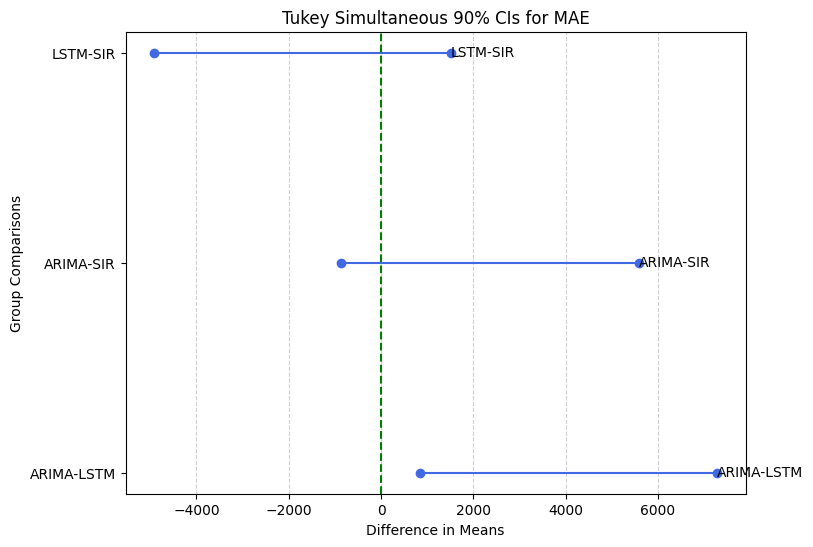



Index: MAEMEAN
p-value: 9.98756963011063e-09
Multiple Comparison of Means - Tukey HSD, FWER=0.10
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 ARIMA   LSTM    0.043 0.8345 -0.1129 0.1989  False
 ARIMA    SIR   0.4183    0.0  0.2625 0.5742   True
  LSTM    SIR   0.3753    0.0  0.2195 0.5312   True
---------------------------------------------------


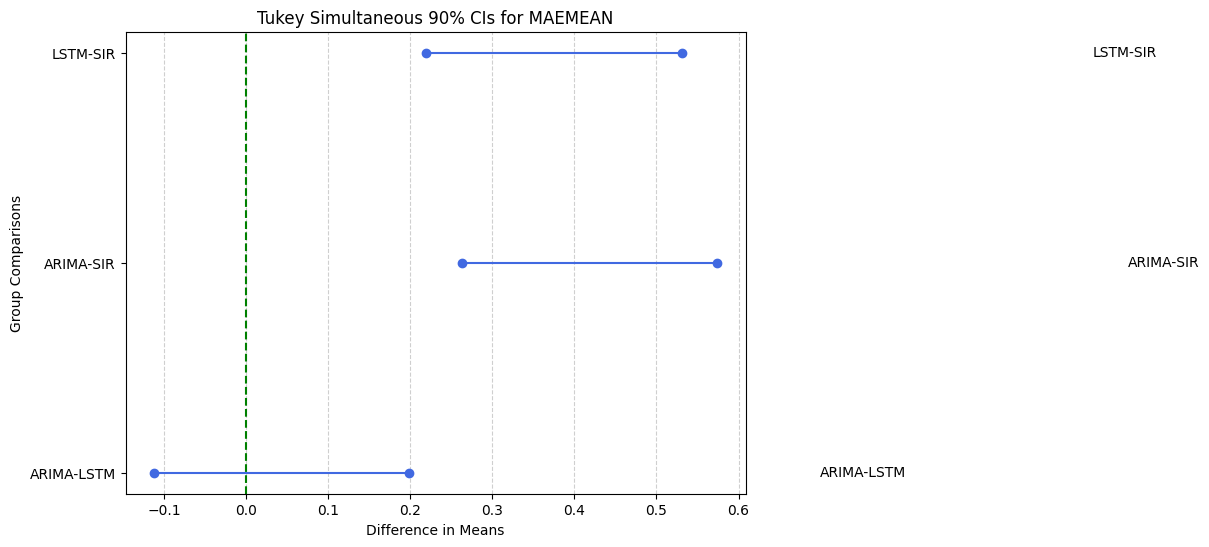



Index: RMSE
p-value: 0.0008349625133306256
    Multiple Comparison of Means - Tukey HSD, FWER=0.10     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
 ARIMA   LSTM  7388.5822 0.2517 -2223.6781 17000.8426  False
 ARIMA    SIR 13992.9767  0.009  4380.7163  23605.237   True
  LSTM    SIR  6604.3944 0.3306 -3007.8659 16216.6548  False
------------------------------------------------------------


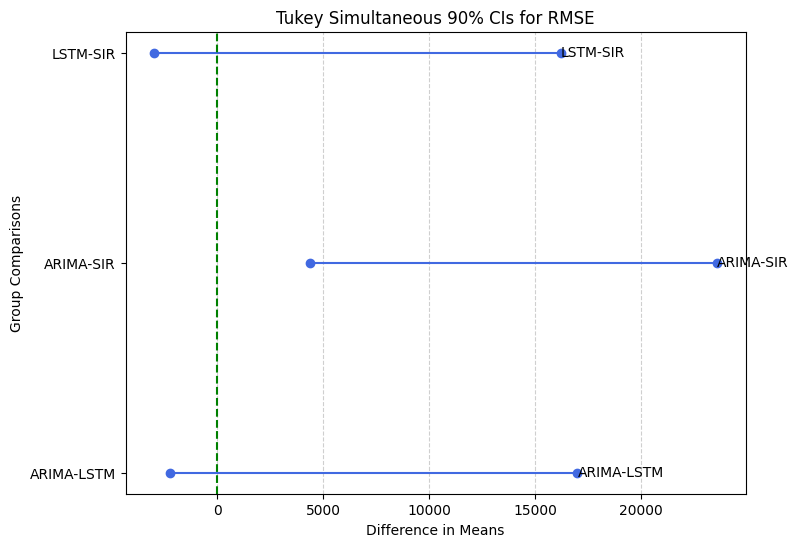



Index: PPE_Value
p-value: 9.177146802996302e-05
      Multiple Comparison of Means - Tukey HSD, FWER=0.10      
group1 group2   meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------
 ARIMA   LSTM   8351.2373 0.9773 -76824.3752  93526.8499  False
 ARIMA    SIR 156321.7257 0.0007  71146.1131 241497.3382   True
  LSTM    SIR 147970.4883 0.0015  62794.8758 233146.1009   True
---------------------------------------------------------------


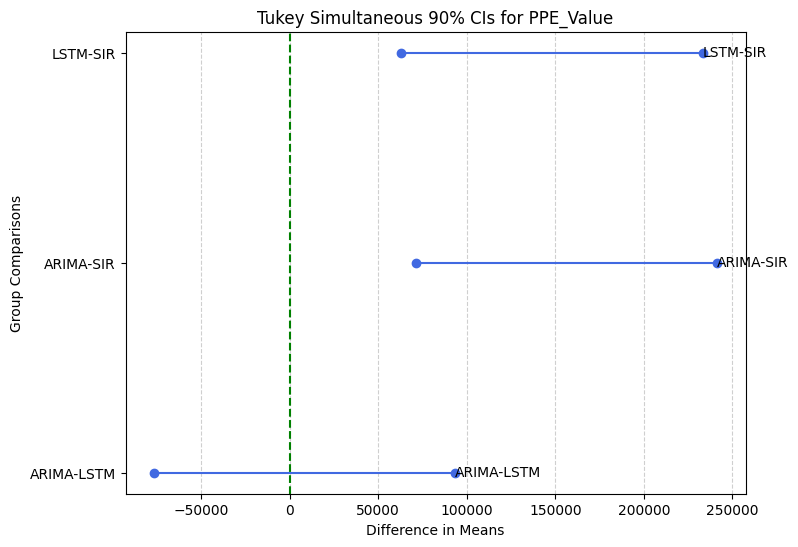



Index: PPE_Time
p-value: 0.06939977005585375
  Multiple Comparison of Means - Tukey HSD, FWER=0.10  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
 ARIMA   LSTM -49.9667 0.1232 -102.4409   2.5075  False
 ARIMA    SIR   3.1333 0.9915  -49.3409  55.6075  False
  LSTM    SIR     53.1 0.0948    0.6258 105.5742   True
-------------------------------------------------------


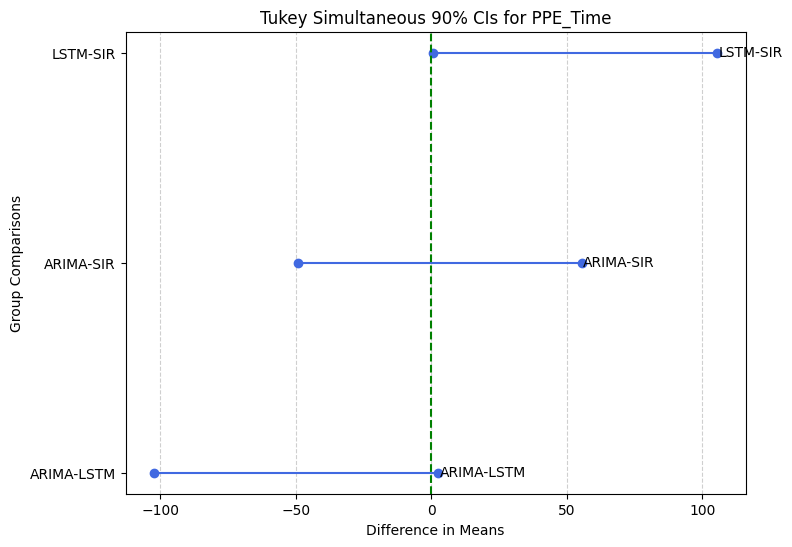

In [11]:
# Perform the ANOVA and Tukey test for each index
for index in ['MAE', 'MAEMEAN', 'RMSE', 'PPE_Value', 'PPE_Time']:
    print(f'Index: {index}')
    p_value, melted_data = anova(data=eval(index.lower()), index=index)
    if p_value < 0.1:
        tukey_result = tukey_test(data=melted_data, index=index)
        plot_tucky(tukey_result, index=index)
    print('\n')
    